In [1]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image
from markov import Markov, predict_valid_sequence
import embeddings as emb
from embeddings import hold_directions2, hold_directions, hold_magnitudes
import torch
from torch.utils.data import Dataset

[14. 14.]
[[-0.76 -0.65]
 [ 0.68 -0.74]]
[0.8]


### Creating SQL Database Connection and Converting tables to dfs ###

In [3]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [4]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

In [5]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [6]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


In [7]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)

### Markov Chain Model

Successfully Trained
Valid Sequence: 1476r15 1132r12 1163r12 1503r15 1525r13 1222r13 1238r13 1287r13 1353r13 1387r14 1454r15 1470r15 1472r15
[(236, 847.0, 5), (381, 826, 2), (255, 742, 2), (190, 719.0, 5), (534, 633.0, 3), (591, 616, 3), (549, 574, 3), (465, 448, 3), (381, 280, 3), (381, 196, 4), (450, 976, 5), (448, 891.0, 5), (620, 891.0, 5)]


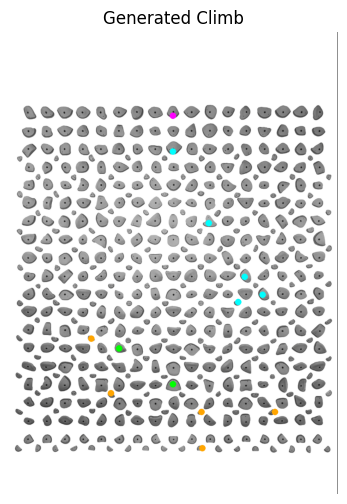

In [8]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1476r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [9]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

### Prepare Data into npz file ###

In [10]:
def get_hold_vector(row, col):
    if not isinstance(row, int):
        raise TypeError(f"Row index must be an integer, got {type(row)} row: {row}")
    if not isinstance(col, int):
        raise TypeError(f"Column index must be an integer, got {type(col)} col: {col}")
    
    if row > 34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    if isinstance(climb_angle, torch.Tensor):
        climb_angle_cpu = climb_angle.cpu().numpy()
    else:
        climb_angle_cpu = np.array(climb_angle)
    climb_angle_radians = np.deg2rad(climb_angle_cpu)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")

def id_to_class_id(id):
    if id <=1089: # 0-16
        class_id = id - 1073 
    elif id <=1395: # 17-322
        class_id = id - 1090 + 17
    elif id <= 1464: # 323-340
        class_id = id - 1447 + 323
    elif id <= 1599: # 341-475
        class_id = id - 1465 + 341
    return class_id

def class_id_to_id(class_id):
    if class_id <= 16:  # 0-16
        id = class_id + 1073
    elif class_id <= 322:  # 17-322
        id = class_id + 1090 - 17
    elif class_id <= 340:  # 323-340
        id = class_id + 1447 - 323
    elif class_id <= 475:  # 341-475
        id = class_id + 1465 - 341 
    return id

def ids_to_hold_val_class_id(hold_class_id, val_class_id):
    hold_val_class_id = (hold_class_id) * 4 + val_class_id
    return hold_val_class_id

def hold_val_class_id_to_ids(hold_val_class_id):
    val_class_id = hold_val_class_id % 4
    hold_class_id = int((hold_val_class_id - val_class_id) /4)
    return hold_class_id, val_class_id

def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_val_class_id, hold_angle, hold_quality, modified_quality, inter_hold_angle, climb_angle, climb_difficulty)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = (matrix - global_means) / global_stds
    return standardized_matrix

def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def hold_to_tuple(hold_class_id, val, climb_angle, climb_difficulty):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = class_id_to_id(int(hold_class_id))
    x, y = id_to_coordinate(hold_id)

    val_class_id = val-2
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    interhold_angle = 0
    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    modified_quality = modified_hold_quality(climb_angle, hold_quality)
    
    feature_tuple = (y, x, val_class_id, hold_class_id, hold_val_class_id, hold_angle, hold_quality, modified_quality, interhold_angle, climb_angle, climb_difficulty)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple

[ 1.72731196e+01  1.70054557e+01  1.63197259e+00  2.24671455e+02
  9.00317794e+02 -3.83938356e-03  5.92423821e-01  9.09554794e-01
  3.91605714e-01  3.59495703e+01  4.72508491e+00]


### RNN Model ###

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)
        self.climb_names = list(self.data.keys())
        self.num_climbs = len(self.climb_names)
    
    def __len__(self):
        return self.num_climbs
    
    def __getitem__(self, idx):
        climb_name = self.climb_names[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix

class RNN(nn.Module):
    def __init__(self, input_size=11, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Task-specific layer for hold_val_class prediction
        self.fc_hold_val_class = nn.Linear(hidden_size, 1904)  # 1904 classes for hold_val_class

    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        hold_val_class_pred = self.fc_hold_val_class(out)
        
        return hold_val_class_pred, hn, cn

# Define collate function for DataLoader to handle variable-length sequences
def collate_fn(batch):
    batch.sort(key=lambda x: len(x), reverse=True)
    sequences = [torch.tensor(x, dtype=torch.float32) for x in batch]
    lengths = torch.tensor([len(x) for x in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, lengths

import torch.nn.functional as F

def custom_loss(pred_class_probabilities, padded_sequences, lengths, beta=1, top_k=5, use_l1=False):
    batch_size = padded_sequences.size(0)
    total_loss = 0.0
    
    for i in range(batch_size):
        climb_angle = padded_sequences[i, lengths[i].cpu().long() - 2, 9].item()
        climb_difficulty = padded_sequences[i, lengths[i].cpu().long() - 2, 10].item()

        
        # Sort and select top-K predicted class probabilities
        values, top_k_indices = torch.topk(pred_class_probabilities[i], k=top_k)
        
        for j in range(top_k):
            pred_class_id = top_k_indices[j]
            pred_hold_id, pred_val_id = hold_val_class_id_to_ids(pred_class_id.item())
            
            pred_tuple = hold_to_tuple(pred_hold_id, pred_val_id, climb_angle, climb_difficulty)
            expected_class_id = padded_sequences[i, lengths[i].cpu().long() - 1, 4].long().item()  # Extract target hold_val_class
            expected_hold_id, expected_val_id = hold_val_class_id_to_ids(expected_class_id)
            expected_tuple = hold_to_tuple(expected_hold_id, expected_val_id, climb_angle, climb_difficulty)
            
            pred_tuple_values = torch.tensor((pred_tuple[0], pred_tuple[1], pred_tuple[5], pred_tuple[6], pred_tuple[7]))# row, col, hold angle, hold quality, modified hold quality
            expected_tuple_values = torch.tensor((expected_tuple[0], expected_tuple[1], expected_tuple[5], expected_tuple[6], expected_tuple[7]))
            
            # Calculate losses for other tuple values (e.g., using L1 or L2 loss)
            if use_l1:
                loss_other_values = F.l1_loss(pred_tuple_values, expected_tuple_values, reduction='sum')
            else:
                loss_other_values = F.mse_loss(pred_tuple_values, expected_tuple_values, reduction='sum')
            
            # Weighted sum or combination of losses
            total_loss += beta * loss_other_values.sum()

    # Average loss over top-K predictions and batch size
    total_loss /= (top_k * batch_size)
    
    return total_loss

# Load your dataset
dataset = ClimbDataset('climb_matrices.npz')

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Initialize the model and move it to GPU if available
model = RNN().to(device)

# Define loss functions
criterion_hold_val_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

beta = 0.5  # Adjust beta as needed for the custom loss
top_k = 50  # Top-k predictions to consider in custom loss

# Number of epochs
num_epochs = 6

# Lists to store loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Iterate over data
    for padded_sequences, lengths in train_loader:
        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute hold_val_class loss
        next_tuple_hold_val_class = padded_sequences[torch.arange(padded_sequences.size(0)), lengths.cpu().long() - 1, 4].long()  # Extract target hold_val_class
        loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, next_tuple_hold_val_class)
        
        # Compute custom loss for other tuple values
        # pred_class_probabilities = F.softmax(hold_val_class_pred, dim=1)
        # loss_custom = custom_loss(pred_class_probabilities, padded_sequences, lengths, beta=beta, top_k=top_k)
        
        # Total loss
        # batch_loss = loss_hold_val_class + loss_custom
        batch_loss = loss_hold_val_class
        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
    
    # Compute average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for padded_sequences, lengths in val_loader:
            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)

            # Forward pass
            hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute hold_val_class loss
            next_tuple_hold_val_class = padded_sequences[torch.arange(padded_sequences.size(0)), lengths.cpu().long() - 1, 4].long()  # Extract target hold_val_class
            loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, next_tuple_hold_val_class)

            # Compute custom loss for other tuple values
            # pred_class_probabilities = F.softmax(hold_val_class_pred, dim=1)
            # loss_custom = custom_loss(pred_class_probabilities, padded_sequences, lengths, beta=beta, top_k=top_k)

            # Total loss
            # batch_loss = loss_hold_val_class + loss_custom
            batch_loss = loss_hold_val_class
            running_val_loss += batch_loss.item()

    # Compute average validation loss
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print statistics
    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

print('Finished Training')

# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



Epoch 1, Training Loss: 3.8348828959465027, Validation Loss: 3.570677900314331
Epoch 2, Training Loss: 2.976397816300392, Validation Loss: 2.3934644637107847
Epoch 3, Training Loss: 1.9125699957609177, Validation Loss: 1.5871596438884734


KeyboardInterrupt: 

### Generate RNN Climb ###

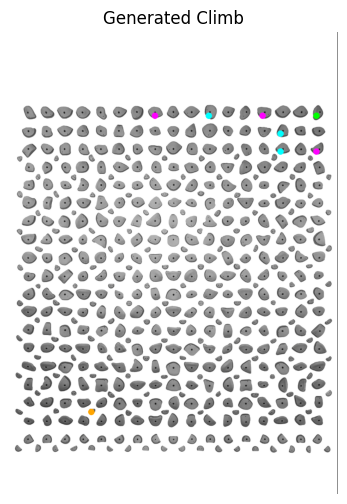

In [ ]:
def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_val_class_id, hold_angle, hold_quality, modified_quality, inter_hold_angle, climb_angle, climb_difficulty)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples



import random

def generate_climb(model, starting_hold_id, starting_val, num_holds, climb_angle, climb_difficulty):
    model.eval()
    
    # Initialize the starting tuple and convert to tensor
    starting_class_id = id_to_class_id(starting_hold_id)
    current_tuple = torch.tensor([hold_to_tuple(starting_class_id, starting_val, climb_angle, climb_difficulty)], dtype=torch.float).unsqueeze(0).to(device)

    generated_hold_ids = [starting_hold_id]
    generated_vals = [starting_val]

    # Initialize hidden states
    h0, c0 = None, None
    
    with torch.no_grad():
        for _ in range(num_holds - 1):
            lengths = torch.tensor([current_tuple.size(1)], dtype=torch.int64).to(device)

            hold_val_class_prob, h0, c0 = model(current_tuple, lengths, h0, c0)
            
            hold_val_top_indices = torch.topk(hold_val_class_prob, k=10, dim=1)[1].squeeze().tolist()
            # print(f"Hold_id_prob len: {hold_id_prob.size()}")
            hold_val_class_id = random.choice(hold_val_top_indices)
            hold_class_id, val_class = hold_val_class_id_to_ids(hold_val_class_id)
            # print(f"hold#{_}\nhold_val_class_id:{hold_val_class_id}\nhold_class_id/val_class: {hold_class_id}/{val_class}\nhold_id:{class_id_to_id(hold_class_id)}")
            generated_hold_ids.append(class_id_to_id(hold_class_id))
            generated_vals.append(val_class)

            # Prepare the next input
            next_tuple = hold_to_tuple(hold_class_id, val_class, climb_angle, climb_difficulty)
            next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
            # Concatenate next_tensor along the sequence dimension (dim=1)
            current_tuple = torch.cat((current_tuple, next_tensor), dim=1)
    
    return generated_hold_ids, generated_vals

def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

hold_ids, vals = generate_climb(model, 1467, 3, 12, 45, 5)
climb_to_image(hold_ids, vals)


In [ ]:
print(hold_ids, vals)

[1467, 1458, 1128, 1127, 1144, 1163, 1198, 1198, 1200, 1198, 1198, 1200, 1198, 1200, 1198, 1200, 1198, 1198, 1200, 1198, 1200, 1198, 1200, 1200, 1200, 1198] [3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
